In [1]:
### Automate All Notebooks
### Financial Feasibility Model: 1 MW Solar + 4-Hour BESS in NYISO Zone A
"""
This notebook runs the entire project end-to-end using the modular codebase in `src/`.

It generates:
- Solar generation results  
- NYISO price alignment  
- Combined revenue model 
- BESS arbitrage performance   
- Full financial model (NPV, IRR, Payback)  
- Sensitivity analysis  
- Key charts for presentation  

All model inputs are controlled by `config.yaml`.
"""

'\nThis notebook runs the entire project end-to-end using the modular codebase in `src/`.\n\nIt generates:\n- Solar generation results  \n- NYISO price alignment  \n- Combined revenue model \n- BESS arbitrage performance   \n- Full financial model (NPV, IRR, Payback)  \n- Sensitivity analysis  \n- Key charts for presentation  \n\nAll model inputs are controlled by `config.yaml`.\n'

In [2]:
### Import Libraries
import sys, os
sys.path.append(os.path.abspath(".."))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")

from src.config_loader import load_config
cfg = load_config()
from src.data_loader import load_solar_data, load_price_data, load_bess_data
from src.solar_profile import build_solar_profile
from src.bess import run_bess_model
from src.financials import (
    combine_solar_bess,
    annualize_revenue,
    summarize_from_annual_df,
    visualize_cashflows
)

DATA_DIR = "../data/nyiso"
OUTPUT_DIR = "../outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

project_root = r"C:\Users\olena\solar_finance_model"
os.chdir(project_root)

print("Working directory set to:", os.getcwd())

Working directory set to: C:\Users\olena\solar_finance_model


In [3]:
solar = load_solar_data(cfg)
prices = load_price_data(cfg)
bess = load_bess_data(cfg)

print("Solar rows:", len(solar))
print("Prices rows:", len(prices))
print("BESS rows: ", len(bess))

Solar rows: 8784
Prices rows: 8784
BESS rows:  8784


In [4]:
solar = solar.join(prices[["DAM_LBMP"]], how="left")

In [5]:
combined = combine_solar_bess(solar, bess, price_col="DAM_LBMP")

print("Combined revenue preview:")
combined.head()

Combined revenue preview:


,AC_MWh,DAM_LBMP,price,SOC_MWh,charge_MW,discharge_MW,charge_cost_$,discharge_rev_$,net_revenue_$,throughput_MWh,charge_energy_MWh,discharge_energy_MWh,solar_revenue_$,bess_revenue_$,total_revenue_$
2024-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2024-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2024-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2024-01-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2024-01-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN


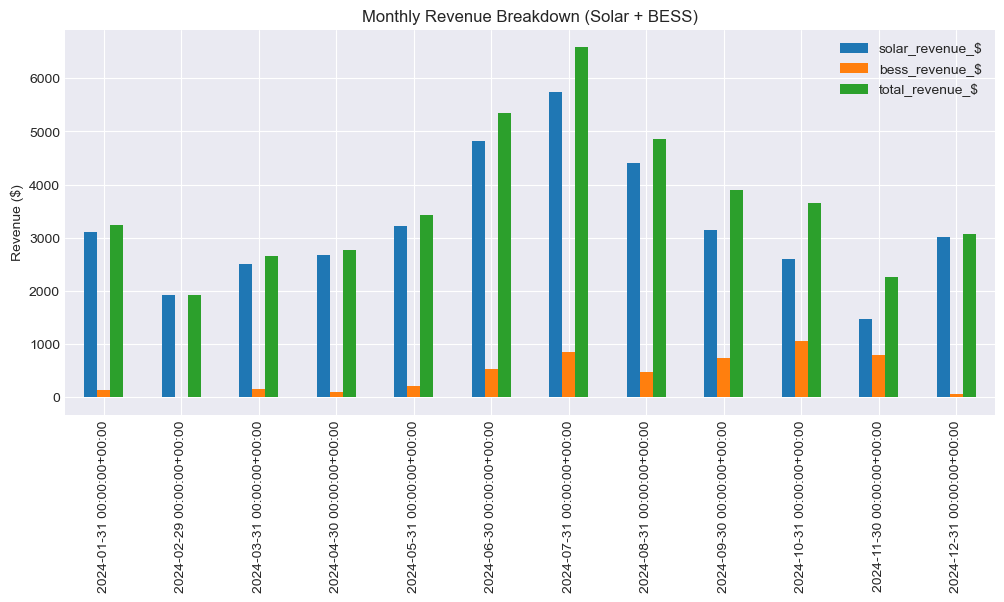

,solar_revenue_$,bess_revenue_$,total_revenue_$
2024-01-31 00:00:00+00:00,3113.147626,129.153842,3242.301468
2024-02-29 00:00:00+00:00,1925.975907,-5.750789,1920.225118
2024-03-31 00:00:00+00:00,2509.776575,151.938316,2661.714891
2024-04-30 00:00:00+00:00,2674.861233,96.054105,2770.915338
2024-05-31 00:00:00+00:00,3221.898122,209.877737,3431.775859
2024-06-30 00:00:00+00:00,4819.744842,524.257316,5344.002158
2024-07-31 00:00:00+00:00,5746.633526,838.426500,6585.060026
2024-08-31 00:00:00+00:00,4401.898362,462.801605,4864.699967
2024-09-30 00:00:00+00:00,3151.693334,742.393105,3894.086439
2024-10-31 00:00:00+00:00,2596.947765,1050.703316,3647.651081


In [6]:
monthly = combined.resample("ME")[[
    "solar_revenue_$",
    "bess_revenue_$",
    "total_revenue_$"
]].sum()

monthly.plot(kind="bar", figsize=(12,5))
plt.title("Monthly Revenue Breakdown (Solar + BESS)")
plt.ylabel("Revenue ($)")
plt.show()

monthly

In [7]:
annual = annualize_revenue(combined)
display(annual)

base_year = annual.index.min()
base_solar = annual.loc[base_year, "solar_revenue_$"]
base_bess  = annual.loc[base_year, "bess_revenue_$"]

print("BASE YEAR:", base_year)
print("Solar Revenue:", round(base_solar, 2))
print("BESS Revenue:", round(base_bess, 2))
print("Total:", round(base_solar + base_bess, 2))

,solar_revenue_$,bess_revenue_$,total_revenue_$
2024,38639.573769,5059.147605,43698.721374


BASE YEAR: 2024
Solar Revenue: 38639.57
BESS Revenue: 5059.15
Total: 43698.72


In [8]:
summary, cashflows = summarize_from_annual_df(annual)

print("=== FINANCIAL SUMMARY ===")
for k, v in summary.items():
    print(f"{k:35s}: {v}")

display(cashflows.head())

=== FINANCIAL SUMMARY ===
NPV ($M)                           : -1.9739718006216411
IRR (%)                            : -8.137469913378403
Initial Investment ($)             : 2100000.0
Solar CAPEX ($M)                   : 1.2
BESS CAPEX ($M)                    : 1.8
Discount Rate                      : 0.07
Escalation Rate                    : 0.02
Inflation Rate                     : 0.025


,Year,Cashflow
0,0,-2.100000e+06
1,1,2.869872e+04
2,2,2.889743e+04
3,3,2.909534e+04
4,4,2.929235e+04


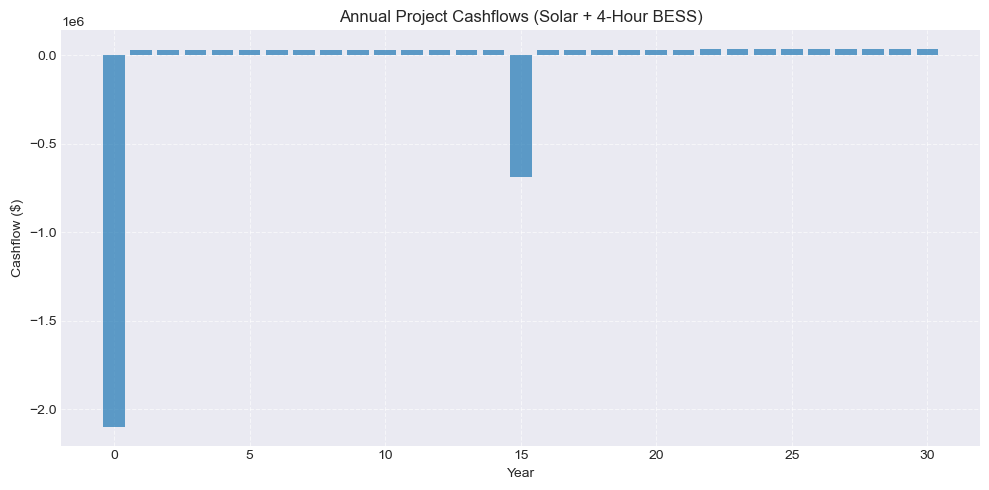

In [9]:
visualize_cashflows(cashflows)

In [10]:
os.makedirs("outputs/master_run", exist_ok=True)

annual.to_csv("outputs/master_run/annual_revenue.csv")
combined.to_csv("outputs/master_run/hourly_combined.csv")
cashflows.to_csv("outputs/master_run/cashflows.csv")

import json
with open("outputs/master_run/financial_summary.json", "w") as f:
    import json
    json.dump(summary, f, indent=4)

print("Saved all outputs to outputs/master_run/")

Saved all outputs to outputs/master_run/


In [11]:
#### Visualizations ###

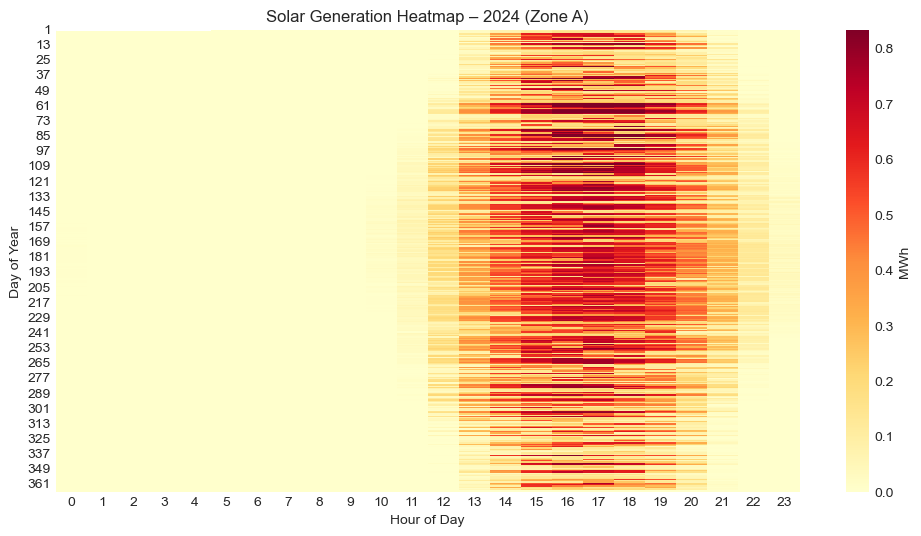

In [12]:
# Solar Generation Heatmap
import seaborn as sns

# Prepare heatmap matrix: day of year vs hour of day
solar_matrix = solar["AC_MWh"].copy()
solar_matrix = solar_matrix.reset_index()
solar_matrix["day"] = solar_matrix["index"].dt.dayofyear
solar_matrix["hour"] = solar_matrix["index"].dt.hour

pivot = solar_matrix.pivot(index="day", columns="hour", values="AC_MWh")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={'label': 'MWh'})
plt.title("Solar Generation Heatmap – 2024 (Zone A)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Year")
plt.show()

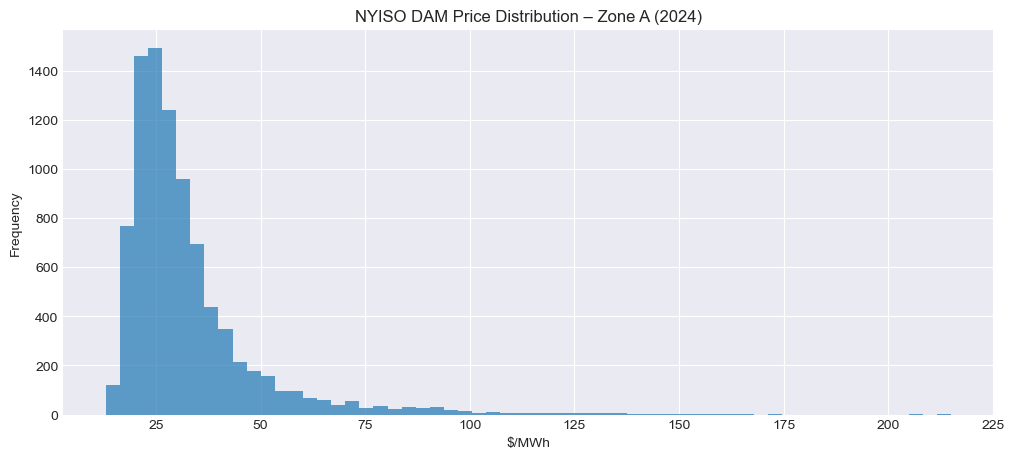

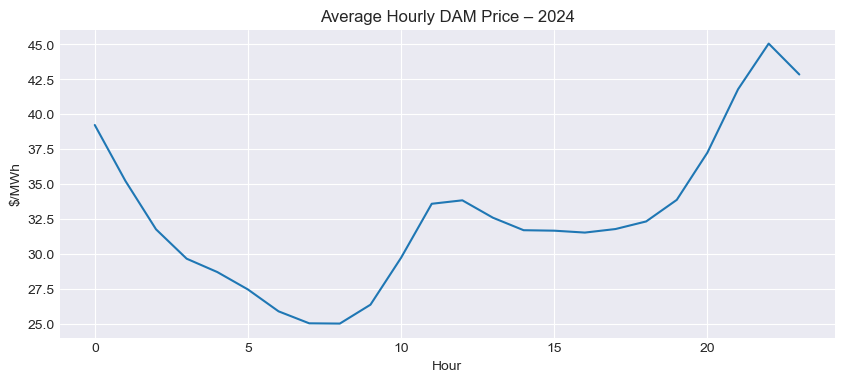

In [13]:
# NYISO Price Distribution & Hourly Profile
plt.figure(figsize=(12,5))
plt.hist(prices["DAM_LBMP"].dropna(), bins=60, alpha=0.7)
plt.title("NYISO DAM Price Distribution – Zone A (2024)")
plt.xlabel("$/MWh")
plt.ylabel("Frequency")
plt.show()

# Hourly average profile
hourly_profile = prices["DAM_LBMP"].groupby(prices.index.hour).mean()

plt.figure(figsize=(10,4))
hourly_profile.plot()
plt.title("Average Hourly DAM Price – 2024")
plt.xlabel("Hour")
plt.ylabel("$/MWh")
plt.show()

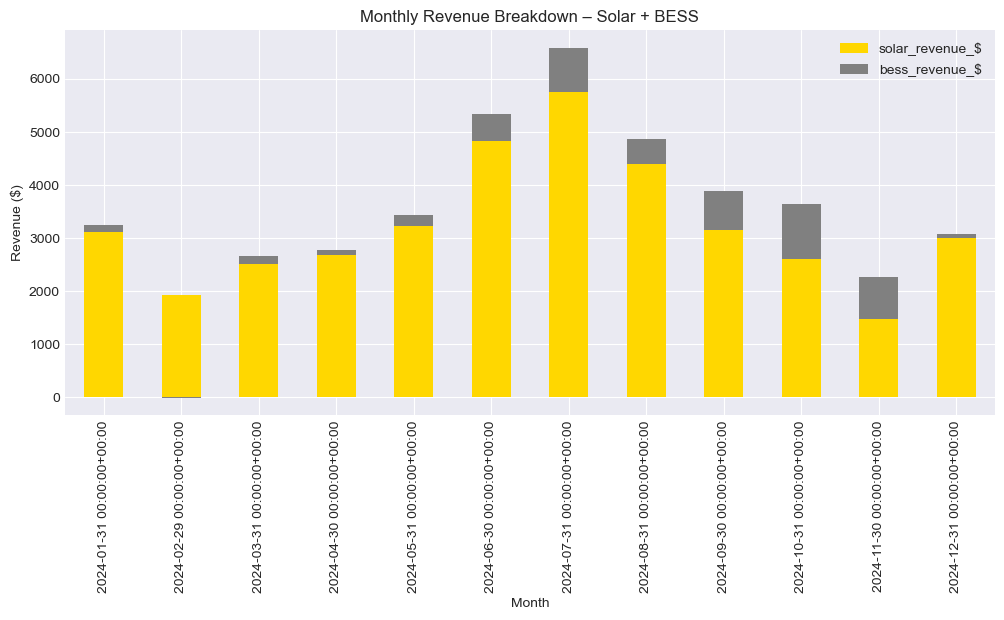

In [14]:
# Monthly Revenue Breakdown
monthly_revenue = combined.resample("ME")[
    ["solar_revenue_$", "bess_revenue_$", "total_revenue_$"]
].sum()

monthly_revenue[["solar_revenue_$", "bess_revenue_$"]].plot(
    kind="bar", stacked=True, figsize=(12,5), color=["gold", "gray"]
)

plt.title("Monthly Revenue Breakdown – Solar + BESS")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.show()

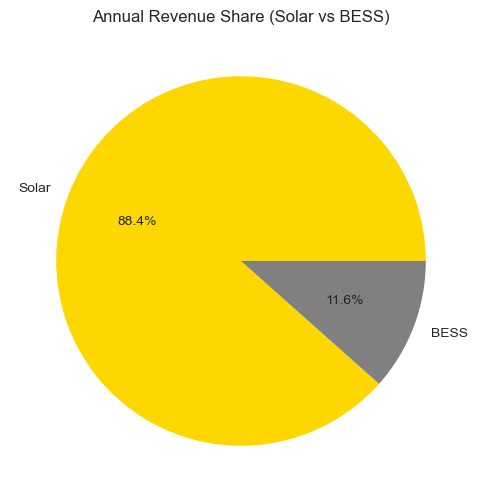

In [15]:
# Solar vs BESS Revenue Chart
total_solar = combined["solar_revenue_$"].sum()
total_bess  = combined["bess_revenue_$"].sum()

plt.figure(figsize=(6,6))
plt.pie(
    [total_solar, total_bess],
    labels=["Solar", "BESS"],
    autopct="%1.1f%%",
    colors=["gold", "gray"]
)
plt.title("Annual Revenue Share (Solar vs BESS)")
plt.show()

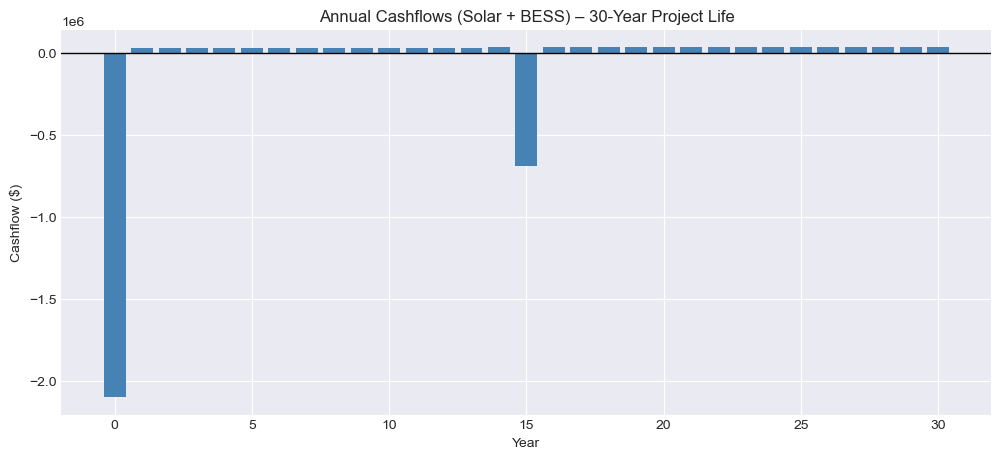

In [16]:
# Cashflow over Time
summary, cashflows_df = summarize_from_annual_df(annual)

plt.figure(figsize=(12,5))
plt.bar(cashflows_df["Year"], cashflows_df["Cashflow"], color="steelblue")
plt.title("Annual Cashflows (Solar + BESS) – 30-Year Project Life")
plt.xlabel("Year")
plt.ylabel("Cashflow ($)")
plt.axhline(0, color="black", linewidth=1)
plt.show()

C:\Users\olena\AppData\Local\Temp\ipykernel_35088\1866837606.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(steps, rotation=45, ha="right")


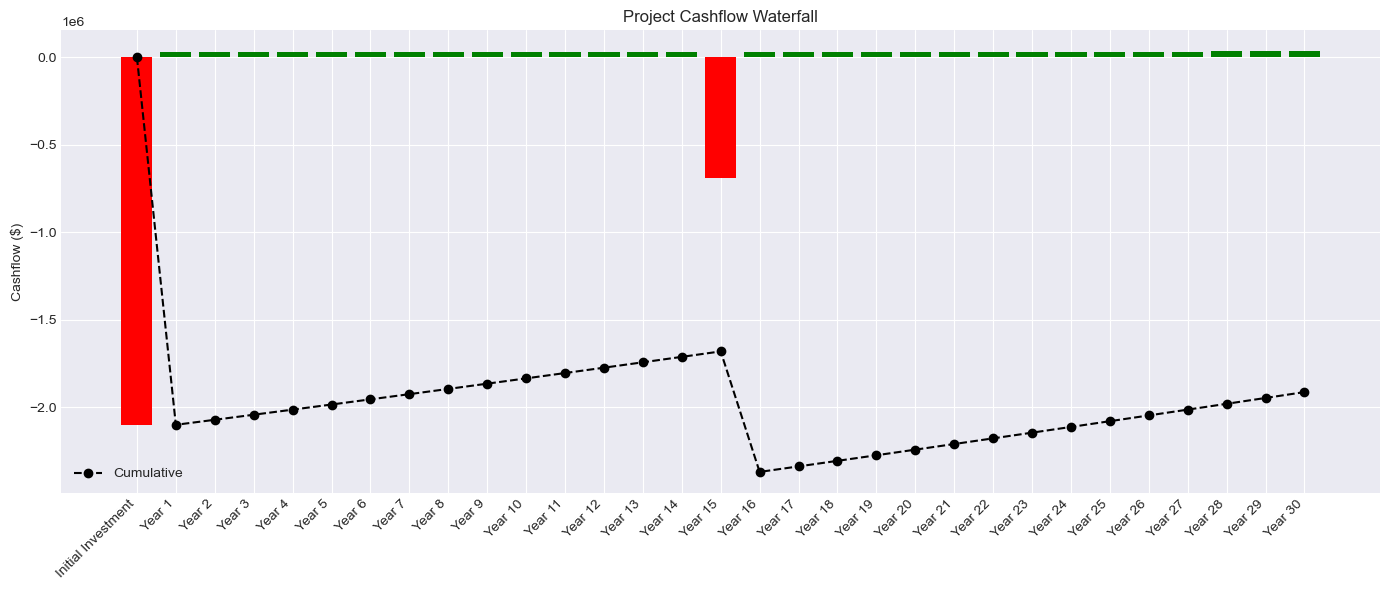

In [17]:
# Waterfall chart from annual cashflows
def plot_waterfall(cashflows_df, title="Project Cashflow Waterfall"):
    vals = cashflows_df["Cashflow"].values

    # Waterfall steps
    steps = ["Initial Investment"] + [f"Year {i}" for i in range(1, len(vals))]

    fig, ax = plt.subplots(figsize=(14, 6))

    running_total = 0
    totals = [running_total]

    for i, v in enumerate(vals):
        running_total += v
        totals.append(running_total)

    # Colors: red for negative, green for positive
    colors = ["red" if v < 0 else "green" for v in vals]

    # Plot the bars
    ax.bar(steps, vals, color=colors)

    # Add cumulative total line
    ax.plot(totals[:-1], color="black", marker="o", linestyle="--", label="Cumulative")

    ax.set_title(title)
    ax.set_ylabel("Cashflow ($)")
    ax.set_xticklabels(steps, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()


# Call it:
plot_waterfall(cashflows_df)

In [18]:
# Sensitivity Analysis

In [19]:
def run_sensitivity(annual, param_name, values, setter_fn):
    """
    Applies a setter function to update cfg values dynamically,
    recomputes the financials each time, and records NPV/IRR.
    """
    results = []
    for val in values:
        setter_fn(val)
        summary, _ = summarize_from_annual_df(annual, cfg)
        results.append({
            "Parameter": param_name,
            "Value": val,
            "NPV ($M)": summary["NPV ($M)"],
            "IRR (%)": summary["IRR (%)"],
        })
    return pd.DataFrame(results)

In [20]:
def set_discount_rate(val):
    cfg["financials"]["discount_rate"] = val

def set_revenue_escalation(val):
    cfg["financials"]["escalation_rate"] = val

def set_solar_capex(val):
    cfg["capex"]["solar_per_mw"] = val

def set_bess_capex(val):
    cfg["capex"]["bess_per_mwh"] = val

In [21]:
discount_sens = run_sensitivity(
    annual,
    param_name="Discount Rate",
    values=[0.05, 0.07, 0.10, 0.12, 0.15],
    setter_fn=set_discount_rate
)

revenue_sens = run_sensitivity(
    annual,
    param_name="Revenue Escalation Rate",
    values=[0.00, 0.01, 0.02, 0.03, 0.05],
    setter_fn=set_revenue_escalation
)

solar_capex_sens = run_sensitivity(
    annual,
    param_name="Solar CAPEX ($/MW)",
    values=[900000, 1200000, 1500000],
    setter_fn=set_solar_capex
)

bess_capex_sens = run_sensitivity(
    annual,
    param_name="BESS CAPEX ($/MWh)",
    values=[300000, 450000, 600000],
    setter_fn=set_bess_capex
)

In [22]:
# Sensitivity Table
sens_table = pd.concat([
    discount_sens,
    revenue_sens,
    solar_capex_sens,
    bess_capex_sens
], ignore_index=True)

display(sens_table)

,Parameter,Value,NPV ($M),IRR (%)
0,Discount Rate,0.05,-1.967509,-8.137470
1,Discount Rate,0.07,-1.973972,-8.137470
2,Discount Rate,0.10,-1.976016,-8.137470
3,Discount Rate,0.12,-1.975933,-8.137470
4,Discount Rate,0.15,-1.976112,-8.137470
5,Revenue Escalation Rate,0.00,-2.018488,-16.113067
6,Revenue Escalation Rate,0.01,-1.998490,-11.133290
7,Revenue Escalation Rate,0.02,-1.976112,-8.137470
8,Revenue Escalation Rate,0.03,-1.950973,-5.896792
9,Revenue Escalation Rate,0.05,-1.890535,-2.441631


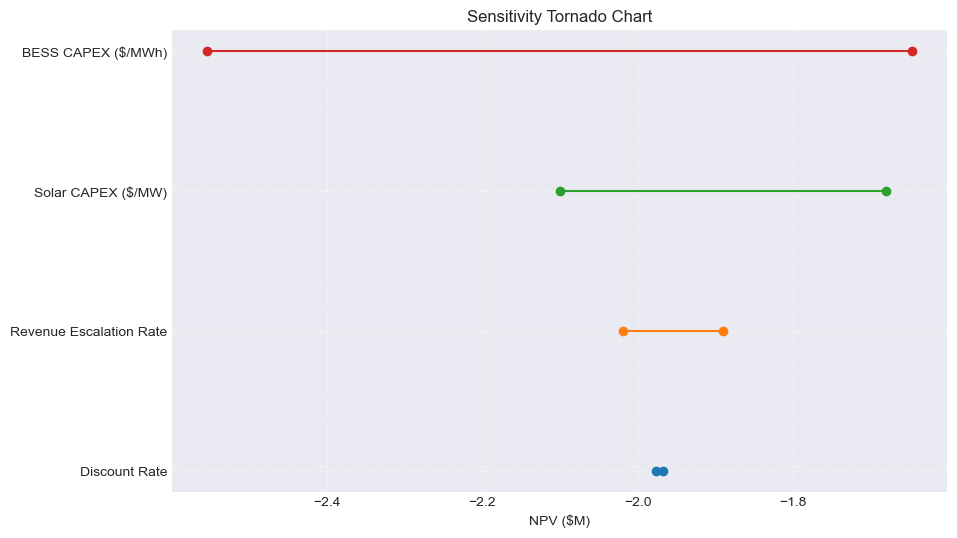

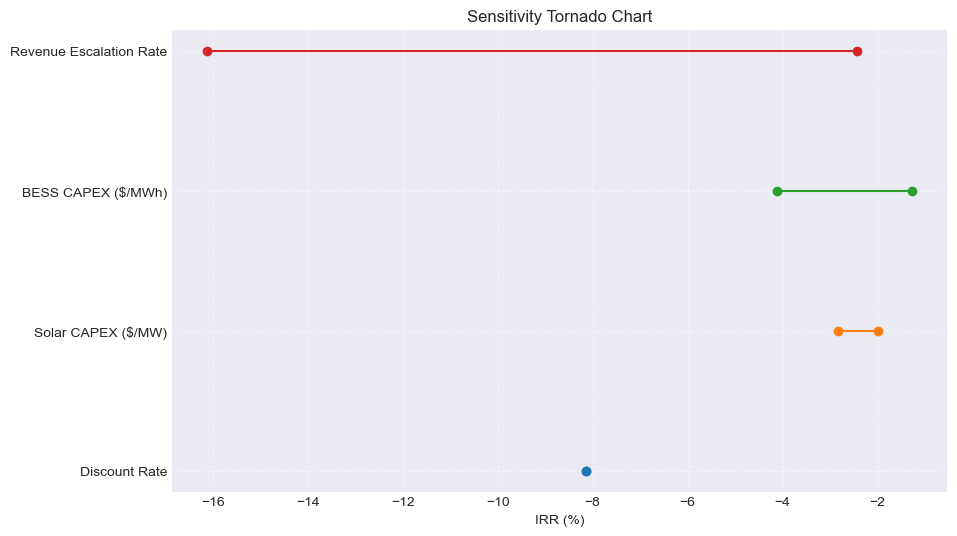

In [23]:
def tornado_chart(sens_table, metric="NPV ($M)", title="Sensitivity Tornado Chart"):
    """
    Creates a tornado chart for a given metric (NPV or IRR).
    """
    # Get mid value for each parameter
    grouped = sens_table.groupby("Parameter")

    chart_data = []
    for param, df in grouped:
        min_val = df[metric].min()
        max_val = df[metric].max()
        chart_data.append([param, min_val, max_val])

    tornado_df = pd.DataFrame(chart_data, columns=["Parameter", "Min", "Max"])
    tornado_df["Spread"] = tornado_df["Max"] - tornado_df["Min"]
    tornado_df = tornado_df.sort_values("Spread", ascending=True)

    # Plot
    plt.figure(figsize=(10, 6))
    for i, row in tornado_df.iterrows():
        plt.plot([row["Min"], row["Max"]], [row["Parameter"], row["Parameter"]], marker="o")

    plt.title(title)
    plt.xlabel(metric)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()


# Call it
tornado_chart(sens_table, metric="NPV ($M)")
tornado_chart(sens_table, metric="IRR (%)")

In [24]:
### Scenario Comparison

In [25]:
import numpy as np
import numpy_financial as npf

# 5-year MACRS depreciation schedule (for energy property)
MACRS_5YR = np.array([0.20, 0.32, 0.192, 0.1152, 0.1152, 0.0576])

# Assumed combined tax rate (federal + state)
TAX_RATE = 0.26  # 26%

In [26]:
def build_incentive_cashflows(
    annual,
    itc_total,          # total ITC fraction (e.g., 0.30, 0.40, 0.50)
    nysun_per_watt,     # NY-Sun upfront incentive in $/W (e.g., 0.25)
    use_macrs,          # True/False
    tax_rate=TAX_RATE,
    label="Scenario"
):
    """
    Build after-tax cashflows including:
    - ITC (as % of total CAPEX)
    - NY-Sun per-watt incentive (upfront)
    - Optional MACRS 5-year depreciation tax shield
    """

    # Pull inputs from cfg
    capacity_mw      = cfg["project"]["capacity_mw"]
    project_life     = cfg["project"]["project_life"]
    discount_rate    = cfg["financials"]["discount_rate"]
    escalation       = cfg["financials"]["escalation_rate"]
    inflation        = cfg["financials"]["inflation_rate"]

    solar_capex_per_mw = cfg["capex"]["solar_per_mw"]
    bess_capex_per_mwh = cfg["capex"]["bess_per_mwh"]
    duration_hours     = cfg["bess"]["duration_hours"]

    solar_deg    = cfg["solar_generation"]["solar_degradation"]
    bess_deg     = cfg["bess"]["bess_degradation"]
    repl_year    = cfg["bess"]["battery_replacement_year"]
    repl_frac    = cfg["bess"]["battery_replacement_cost_frac"]

    opex_base = cfg["financials"]["o_and_m_per_mw"] * capacity_mw

    # Capital costs
    intercon = cfg["capex"].get("interconnection_cost", 0)

    solar_capex = solar_capex_per_mw * capacity_mw
    bess_capex  = bess_capex_per_mwh * capacity_mw * duration_hours
    gross_capex = solar_capex + bess_capex + intercon

    # ITC applied on total CAPEX
    itc_amount = itc_total * gross_capex

    # NY-Sun incentive (per W of AC capacity)
    nysun_incentive = nysun_per_watt * capacity_mw * 1_000_000.0  # MW → W

    # Effective initial cashflow (t = 0)
    # Convention: CAPEX outflow (negative), incentives/ITC positive
    initial_cf = -gross_capex + itc_amount + nysun_incentive

    # Revenue baseline from annual df
    base_solar = annual.iloc[0]["solar_revenue_$"]
    base_bess  = annual.iloc[0]["bess_revenue_$"]

    # Depreciation basis (usual rule: reduce by 50% of ITC)
    if use_macrs:
        depreciable_basis = gross_capex * (1 - 0.5 * itc_total)
    else:
        depreciable_basis = 0.0

    cashflows = [initial_cf]

    for y in range(project_life):
        # Revenue with degradation + escalation
        solar_rev = base_solar * ((1 - solar_deg) ** y) * ((1 + escalation) ** y)
        bess_rev  = base_bess  * ((1 - bess_deg) ** y)  * ((1 + escalation) ** y)
        revenue   = solar_rev + bess_rev

        # O&M with inflation
        opex = opex_base * ((1 + inflation) ** y)

        # Pre-tax operating cashflow
        pre_tax = revenue - opex

        # Battery replacement (capex outflow in that year)
        if (y + 1) == repl_year:
            pre_tax -= bess_capex * repl_frac

        # MACRS depreciation
        if use_macrs and y < len(MACRS_5YR):
            depreciation = depreciable_basis * MACRS_5YR[y]
        else:
            depreciation = 0.0

        taxable_income = pre_tax - depreciation

        # Allow negative taxable income → tax benefit
        tax = taxable_income * tax_rate

        after_tax_cf = pre_tax - tax
        cashflows.append(after_tax_cf)

    # NPV and IRR
    npv = cashflows[0] + npf.npv(discount_rate, cashflows[1:])
    irr = npf.irr(cashflows)

    summary = {
        "Scenario": label,
        "NPV ($M)": npv / 1_000_000,
        "IRR (%)": float(irr * 100) if irr is not None else np.nan,
        "Initial Investment Effective ($)": -initial_cf,
        "Gross CAPEX ($M)": gross_capex / 1_000_000,
        "Solar CAPEX ($M)": solar_capex / 1_000_000,
        "BESS CAPEX ($M)": bess_capex / 1_000_000,
        "ITC (%)": itc_total * 100,
        "NY-Sun ($/W)": nysun_per_watt,
        "Use MACRS": use_macrs,
        "Tax Rate": tax_rate,
    }

    cashflow_df = pd.DataFrame({
        "Year": list(range(len(cashflows))),
        "Cashflow": cashflows
    })

    return summary, cashflow_df

In [27]:
# Define a list of (label, itc_total, nysun_per_watt, use_macrs)
incentive_scenarios = [
    ("Merchant: No Incentives",          0.00, 0.00, False),
    ("Standard ITC: 30% + MACRS",        0.30, 0.00, True),
    ("Energy Community: 40% + MACRS",    0.40, 0.00, True),
    ("Full Dev: 50% ITC + NY-Sun $0.25/W + MACRS", 0.50, 0.25, True),
]

In [28]:
scenario_summaries = []
scenario_cashflows = {}

from src.config_loader import load_config  # ensure fresh load each loop

for label, itc_frac, nysun_watt, use_macrs in incentive_scenarios:
    
    # Reload config fresh so no other sensitivity values stick around
    cfg = load_config()
    
    summary, cf_df = build_incentive_cashflows(
        annual=annual,
        itc_total=itc_frac,
        nysun_per_watt=nysun_watt,
        use_macrs=use_macrs,
        tax_rate=TAX_RATE,
        label=label,
    )

    scenario_summaries.append(summary)
    scenario_cashflows[label] = cf_df

scenario_df = pd.DataFrame(scenario_summaries).set_index("Scenario")
display(scenario_df)

,NPV ($M),IRR (%),Initial Investment Effective ($),Gross CAPEX ($M),Solar CAPEX ($M),BESS CAPEX ($M),ITC (%),NY-Sun ($/W),Use MACRS,Tax Rate
Scenario,,,,,,,,,,
Merchant: No Incentives,-3.406739,-10.631074,3500000.0,3.5,1.2,1.8,0.0,0.00,False,0.26
Standard ITC: 30% + MACRS,-1.668512,-7.958186,2450000.0,3.5,1.2,1.8,30.0,0.00,True,0.26
Energy Community: 40% + MACRS,-1.358996,-7.313764,2100000.0,3.5,1.2,1.8,40.0,0.00,True,0.26
Full Dev: 50% ITC + NY-Sun $0.25/W + MACRS,-0.799480,-5.586762,1500000.0,3.5,1.2,1.8,50.0,0.25,True,0.26


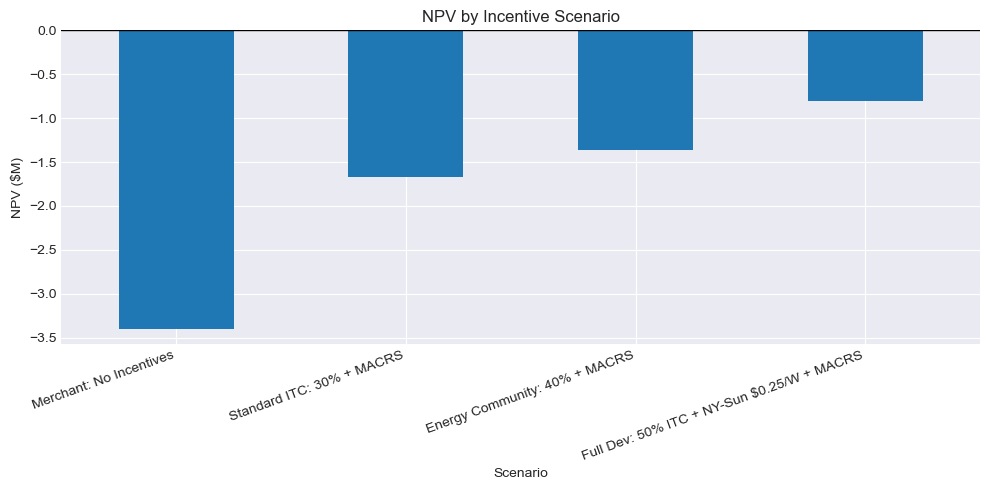

In [29]:
plt.figure(figsize=(10, 5))
scenario_df["NPV ($M)"].plot(kind="bar")
plt.title("NPV by Incentive Scenario")
plt.ylabel("NPV ($M)")
plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

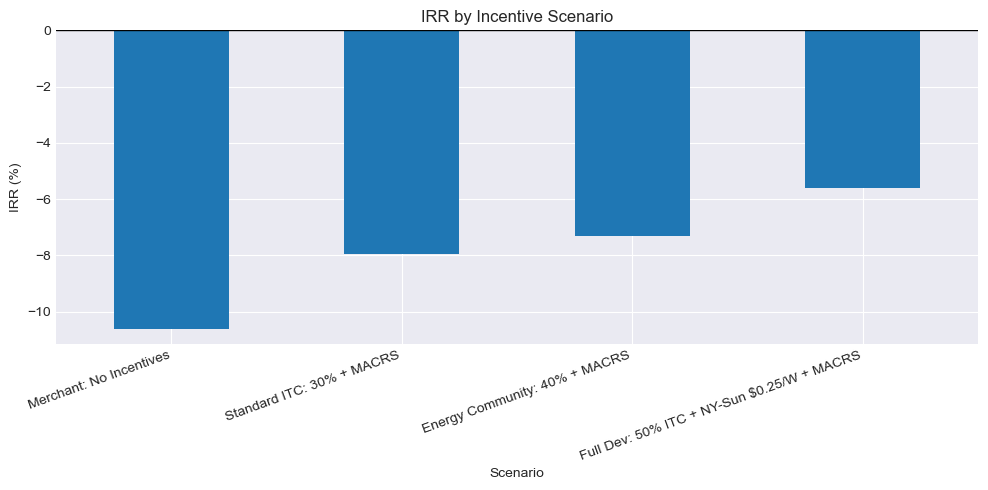

In [30]:
plt.figure(figsize=(10, 5))
scenario_df["IRR (%)"].plot(kind="bar")
plt.title("IRR by Incentive Scenario")
plt.ylabel("IRR (%)")
plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [31]:
summary, _ = build_incentive_cashflows(
    annual=annual,
    itc_total=0.0,
    nysun_per_watt=0.0,
    use_macrs=False,
    tax_rate=TAX_RATE,
    label="Debug"
)

print("Solar CAPEX (internal):", summary["Solar CAPEX ($M)"])
print("BESS CAPEX (internal):", summary["BESS CAPEX ($M)"])
print("Gross CAPEX (internal):", summary["Gross CAPEX ($M)"])

Solar CAPEX (internal): 1.2
BESS CAPEX (internal): 1.8
Gross CAPEX (internal): 3.5


In [32]:
# === FINAL PRESENTATION TABLE ===
final_cols = [
    "NPV ($M)",
    "IRR (%)",
    "Gross CAPEX ($M)",
    "Initial Investment Effective ($)",
    "ITC (%)",
    "NY-Sun ($/W)",
    "Use MACRS",
    "Tax Rate"
]

presentation_table = scenario_df[final_cols].copy()

# Format numbers for clean display
presentation_table["NPV ($M)"] = presentation_table["NPV ($M)"].round(3)
presentation_table["IRR (%)"] = presentation_table["IRR (%)"].round(2)
presentation_table["Gross CAPEX ($M)"] = presentation_table["Gross CAPEX ($M)"].round(2)
presentation_table["Initial Investment Effective ($)"] = presentation_table["Initial Investment Effective ($)"].round(0)
presentation_table["Tax Rate"] = presentation_table["Tax Rate"].round(2)

display(presentation_table.style.format({
    "Initial Investment Effective ($)": "{:,.0f}"
}))


,NPV ($M),IRR (%),Gross CAPEX ($M),Initial Investment Effective ($),ITC (%),NY-Sun ($/W),Use MACRS,Tax Rate
Scenario,,,,,,,,
Merchant: No Incentives,-3.407000,-10.630000,3.500000,"3,500,000",0.000000,0.000000,False,0.260000
Standard ITC: 30% + MACRS,-1.669000,-7.960000,3.500000,"2,450,000",30.000000,0.000000,True,0.260000
Energy Community: 40% + MACRS,-1.359000,-7.310000,3.500000,"2,100,000",40.000000,0.000000,True,0.260000
Full Dev: 50% ITC + NY-Sun $0.25/W + MACRS,-0.799000,-5.590000,3.500000,"1,500,000",50.000000,0.250000,True,0.260000


In [33]:
def plot_incentive_waterfall(summary_dict, title="Incentive Waterfall", capacity_mw=1.0):
    gross_capex = summary_dict["Gross CAPEX ($M)"] * 1_000_000
    itc_pct = summary_dict["ITC (%)"] / 100.0
    nysun_watt = summary_dict["NY-Sun ($/W)"]
    
    itc_amount = -gross_capex * itc_pct
    nysun_amount = -nysun_watt * capacity_mw * 1_000_000
    net_initial = summary_dict["Initial Investment Effective ($)"]

    labels = [
        "Gross CAPEX",
        "ITC Benefit",
        "NY-Sun Incentive",
        "Net Initial Investment"
    ]

    # Final bar is plotted directly as actual out-of-pocket cost
    values = [
        gross_capex,
        itc_amount,
        nysun_amount,
        net_initial
    ]

    # Bottoms:
    cum_bottoms = [
        0,
        gross_capex,
        gross_capex + itc_amount,
        0     # Final bar starts at zero
    ]

    fig, ax = plt.subplots(figsize=(11, 6))

    colors = ["#FFA500", "#4CAF50", "#4CAF50", "#1E88E5"]  # orange, green, green, blue

    bars = ax.bar(labels, values, bottom=cum_bottoms, color=colors)

    # Labels
    for bar, val, bottom in zip(bars, values, cum_bottoms):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bottom + val/2,
            f"${abs(val):,.0f}",
            ha="center", va="center"
        )

    ax.set_title(title)
    ax.set_ylabel("Dollars ($)")
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.show()

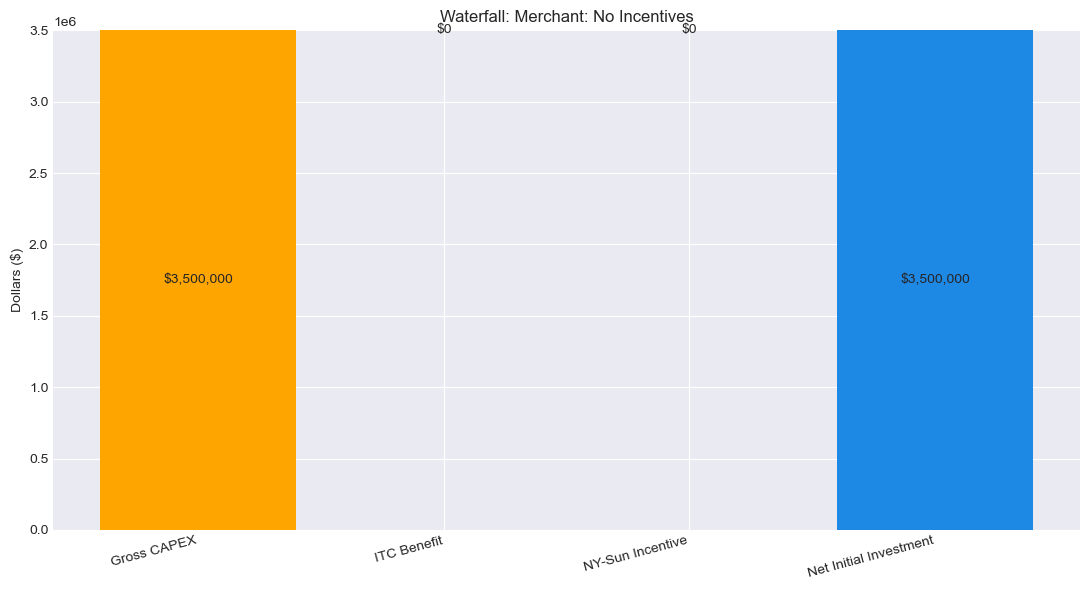

In [34]:
# Select which scenario to plot
scenario_to_plot = "Merchant: No Incentives"
plot_incentive_waterfall(
    scenario_df.loc[scenario_to_plot],
    title=f"Waterfall: {scenario_to_plot}"
)

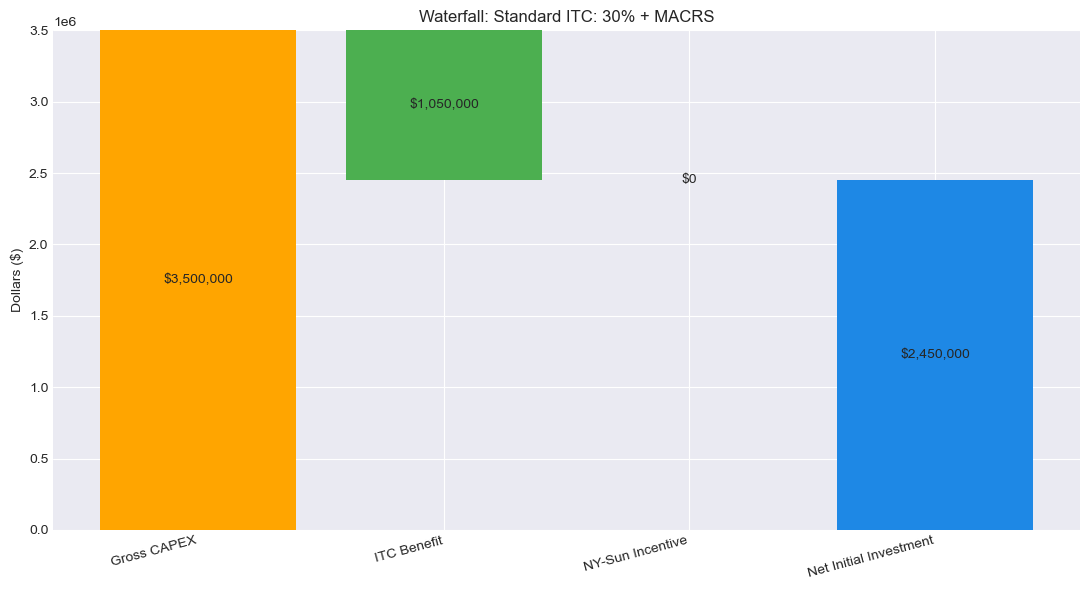

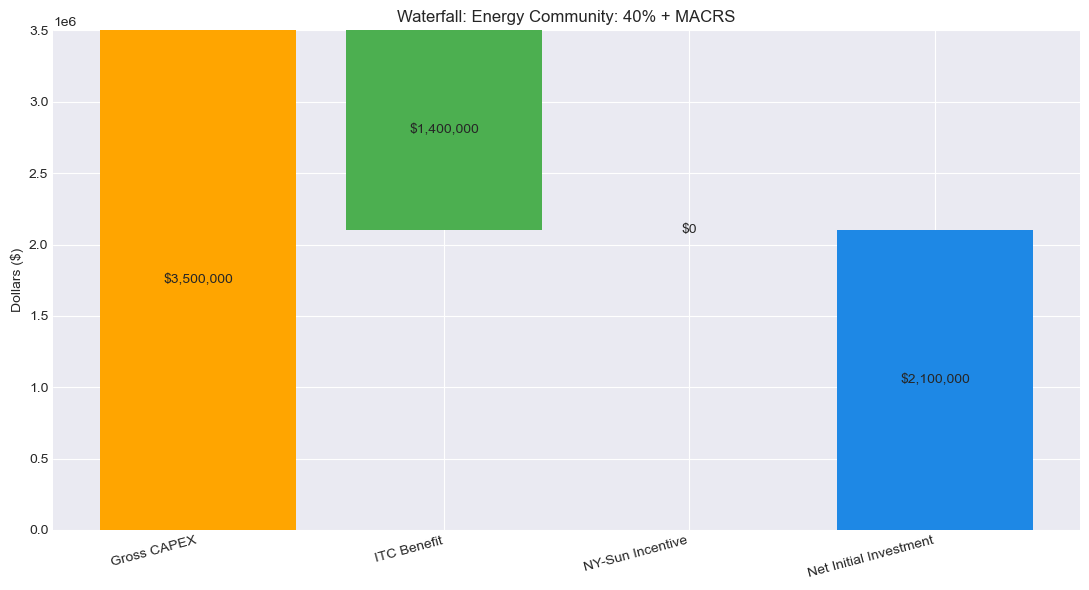

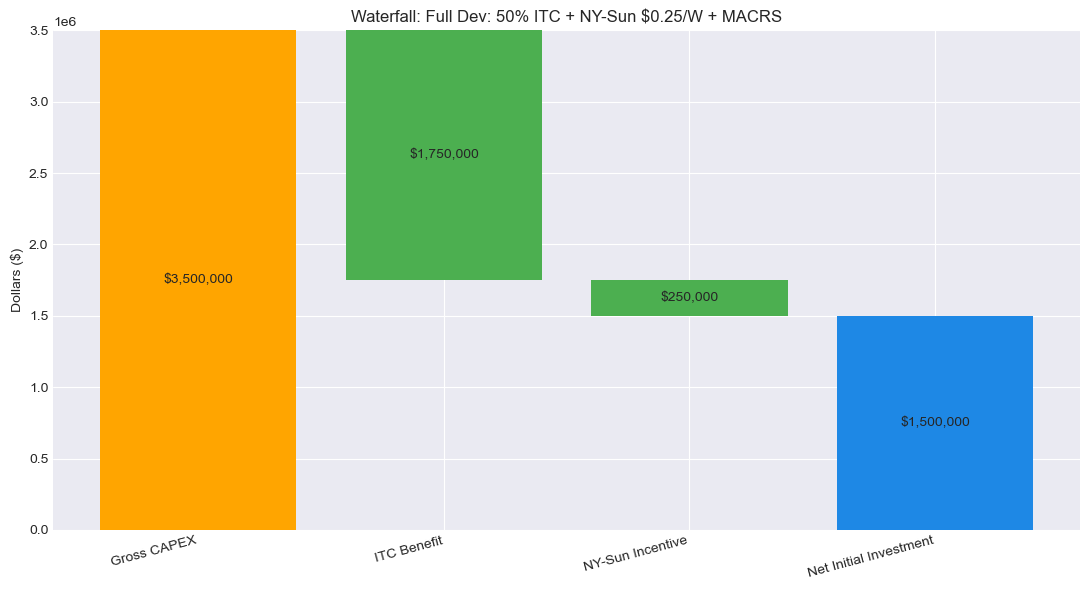

In [35]:
# Select which scenario to plot
scenario_to_plot = "Standard ITC: 30% + MACRS"
plot_incentive_waterfall(
    scenario_df.loc[scenario_to_plot],
    title=f"Waterfall: {scenario_to_plot}"
)

scenario_to_plot = "Energy Community: 40% + MACRS"
plot_incentive_waterfall(
    scenario_df.loc[scenario_to_plot],
    title=f"Waterfall: {scenario_to_plot}"
)

scenario_to_plot = "Full Dev: 50% ITC + NY-Sun $0.25/W + MACRS"
plot_incentive_waterfall(
    scenario_df.loc[scenario_to_plot],
    title=f"Waterfall: {scenario_to_plot}"
)